# Naive Bayes -luokittelua akkujärjestelmille

Tässä luodaan esikäsittelijän ja lisäesikäsittelyn avulla otos datasta, jolla testataan kahden Naive Bayes -luokittelijan kykyä päätellä, onko järjestelmässä akku pelkän hinnan [$/W] ja asentajan perusteella.

## Kirjastot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import importlib.util
import sys
file_path = "../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


## Esikäsittelijän ajaminen

Kutsutaan esikäsittelijää. Käytetään oletusasetuksia eli annetaan parametrina vain lista tarvittavista sarakkeista.

In [2]:
price_col = 'price_per_W'
customer_segment = 'customer_segment'
cols = ['year', price_col, 'installer_name', 'battery_storage', customer_segment]

df_all = esik.esik(cols)

print("df_all.shape:", df_all.shape)


df_all.shape: (1000000, 5)


## Datan käsittely malleja varten

Luokittelun perustana on hinta ja asentaja, joten poistetaan rivit, joilta kyseiset tiedot puuttuvat. Supistetaan testidataa lisää ensimmäisiä testejä varten rajaamalla se yhteen vuoteen ja yhteen asiakassegmenttiin. Joukosta poistetaan myös kalleimmat järjestelmät ja valitaan vain tietty määrä supistetun joukon yleisimpiä asentajia, joista tehdään omat sarakkeet `pd.get_dummies` metodilla. Lopuksi poistetaan sarakkeet, joita ei käytetä mallin ajossa.

In [3]:
top_installers_n = 25
price_limit_quantile = 0.95

df = df_all.copy()
df.dropna(subset=[price_col, 'installer_name'], inplace=True)
print("dropna, df.shape:", df.shape)

df = df[(df['year'] == 2018)]  # Ensimmäinen akku 2008
print("1-year, df.shape:", df.shape)

df = df[(df[customer_segment] == 'RES')]
print("1-segment, df.shape:", df.shape)

price_q = df[price_col].quantile(price_limit_quantile)
print(price_limit_quantile, "quantile:", price_q)
df = df[(df[price_col] <= price_q)]
print("price limit, df.shape:", df.shape)

installers = df['installer_name'].value_counts().head(top_installers_n).index.tolist()
df = df[(df['installer_name'].isin(installers))]
print(top_installers_n, "top installers, df.shape:", df.shape)

display(df['battery_storage'].value_counts())
display(df.groupby(['installer_name']).agg({'battery_storage': ['count', 'mean']}).sort_values(by=('battery_storage', 'mean'), ascending=False).head())
df.rename(columns={'installer_name': 'i'}, inplace=True)
df = pd.get_dummies(df, columns=['i'])

df.drop(['year', customer_segment], axis=1, inplace=True)
print("df.shape:", df.shape)
display(df.head(2))
df_ML = df


dropna, df.shape: (628082, 5)
1-year, df.shape: (103826, 5)
1-segment, df.shape: (101426, 5)
0.95 quantile: 5.74712643678161
price limit, df.shape: (96366, 5)
25 top installers, df.shape: (60828, 5)


0    57720
1     3108
Name: battery_storage, dtype: int64

battery_storage          
                               count      mean
installer_name                                
Rec Solarmmercialrp             1703  0.356430
Sullivan Solar Power             714  0.221289
Petersen Dean                   2284  0.117338
Sunrun                          5462  0.104907
Tesla Energy                   13942  0.097906

df.shape: (60828, 27)


,price_per_W,battery_storage,i_Citadel Roofing And Solar,i_Complete Solar,i_Freedom Forever,i_Hooked On Solar,i_Horizon Solar Power,i_Infinity Energy,i_Leonard Roofing,i_Nb Baker Electric,...,i_Solcius,i_Sullivan Solar Power,i_Sun Solar Energy Solutions,i_Sunpower Capital,i_Sunrun,i_Tesla Energy,i_Tmag Industries Dba Stellar Solar,i_V3 Electric,i_Verengo,i_Vivint Solar Developer
396,4.50,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2096,5.12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Mallien ajo

Käytetään edellisessä lohkossa valikoitua dataa mallien koulutukseen. Aloitetaan jakamalla data opetus- ja testidataa. Tämän jälkeen tehdään hinnan skaalaus välille [0, 1]. Säilytetään kuitenkin alkuperäiset arvot taulukoissa `X_train_orig` ja `X_test_orig`, sillä niitä käytetään myöhemmin tulosten tarkastelussa.

In [4]:
df = df_ML.copy()
X = df.drop('battery_storage', axis=1)
y = df['battery_storage']
X_cols = X.columns

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5451, stratify=y)

mms = MinMaxScaler().fit(X_train_orig)

X_train = pd.DataFrame(mms.transform(X_train_orig), columns=X_cols)
X_test = pd.DataFrame(mms.transform(X_test_orig), columns=X_cols)

X_train.head()


,price_per_W,i_Citadel Roofing And Solar,i_Complete Solar,i_Freedom Forever,i_Hooked On Solar,i_Horizon Solar Power,i_Infinity Energy,i_Leonard Roofing,i_Nb Baker Electric,i_Petersen Dean,...,i_Solcius,i_Sullivan Solar Power,i_Sun Solar Energy Solutions,i_Sunpower Capital,i_Sunrun,i_Tesla Energy,i_Tmag Industries Dba Stellar Solar,i_V3 Electric,i_Verengo,i_Vivint Solar Developer
0,0.867893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.753395,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.120914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.737289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.511057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Luokittelu ja sen tarkkuus

### GaussianNB

In [5]:
gnb = GaussianNB()

y_pred_G = gnb.fit(X_train, y_train).predict(X_test)
acs = accuracy_score(y_test, y_pred_G)
cm = confusion_matrix(y_test, y_pred_G)
print(f'Accuracy: {acs}')
print(f'{cm}')


Accuracy: 0.5633733355252343
[[9352 7965]
 [   3  929]]


### ComplementNB

In [6]:
clf = ComplementNB()

y_pred_C = clf.fit(X_train, y_train).predict(X_test)
acs = accuracy_score(y_test, y_pred_C)
cm = confusion_matrix(y_test, y_pred_C)
print(f'Accuracy: {acs}')
print(f'{cm}')


Accuracy: 0.6480903063181545
[[10937  6380]
 [   42   890]]


## Mitä luokittelu käytännössä teki?

Analyysin syventämiseksi piirretään kuvaajat molemmille malleille sekä alkuperäiselle testisetin datalle. Ilman akkua olevien järjestelmien hintajakauma on kuvassa ylärivillä ja akkujärjestelmien alarivillä.

Tulokset kootaan ensin yhteen taulukkoon (DataFrame).

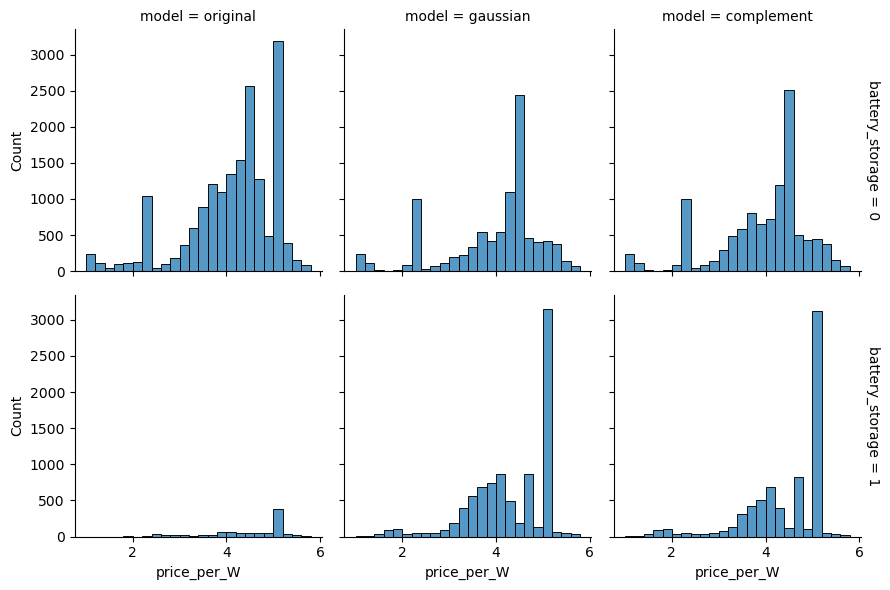

In [7]:
model = 'model'
ind = X_test_orig.index

df_1 = pd.concat([X_test_orig, y_test], axis=1)
df_1[model] = 'original'

df_2 = pd.concat([X_test_orig, pd.Series(y_pred_G, index=ind, name='battery_storage')], axis=1)
df_2[model] = 'gaussian'

df_3 = pd.concat([X_test_orig, pd.Series(y_pred_C, index=ind, name='battery_storage')], axis=1)
df_3[model] = 'complement'

df = pd.concat([df_1, df_2, df_3])

sns.displot(
  df, x=price_col, col=model, row='battery_storage',
  binwidth=.2, height=3, facet_kws=dict(margin_titles=True)
)
plt.show()


Saattoi olla odotettuakin, että Bayes-luokittelijat luokittelevat 5,0-5,2 kohdalla olevan piikin pääsääntöisesti akullisiksi, sillä kyseessä on suurimmaksi osaksi Tesla Energyn samanhintaiset asennukset, joista vain osassa on tietoja akusta. Malli on siis ainakin jossain määrin toiminut niin kuin odotettiin, kun se tulkitsi hinnan ja asentajan perusteella lähes kaikki samassa ryppäässä olleet asennukset akullisiksi.

Mallien tarkkuus jää toki epätarkaksi. Se on toisaalta hyvä merkki, sillä oletus oli, että potentiaalisia akkujärjestelmiä on löydettävissä enemmän kuin mitä datan varmemmat merkit antavat ymmärtää. Mallin varsinaista tarkkuutta ei taas toisaalta voida laskea, koska tarkastusdataa ei oletettujen puutteiden vuoksi ole. Toisin sanoen mallien hyvyyden arviointi on tehtävä vain tuloksen järkevyyden ja realistisuuden perusteella.

### Akkujärjestelmien osuus

Lasketaan vielä akkujärjestelmien osuus kaikista asennuksista kullekin mallille.

In [8]:
display(df.groupby([model]).agg({'battery_storage': ['mean']}))
display(df.groupby([model, 'battery_storage']).agg({price_col: ['count', 'mean']}))


,battery_storage
,mean
model,
complement,0.398378
gaussian,0.487369
original,0.051071


price_per_W          
                                 count      mean
model      battery_storage                      
complement 0                     10979  3.935727
           1                      7270  4.445270
gaussian   0                      9355  3.968283
           1                      8894  4.317986
original   0                     17317  4.117060
           1                       932  4.541122

Alkuperäisessä datassa osuus on noin 5 %. Tämä täsmää hyvin dataa analysoineen _Lawrence Berkeley National Laboratory_:n laskelmiin, mikä herättää epäilyksiä aikaisemmin tehdyn oletuksen pätevyydestä. Oletus, että akkujärjestelmiä olisi enemmän kuin akuista on tietoa, saattaa sittenkin olla väärä. Ehkä sama hinnan ja tehon suhde järjestelmille akulla ja ilman esimerkiksi Tesla Energyn kohdalla johtuu jostain muusta syystä, kuten virheistä hintatiedoissa. Esikäsittelyvaiheessa tuskin onnistuttiin korjaamaan kaikkia epäselvyyksiä hinnoista.

#### Mallin tuloksia asentajien mukaan

Tarkastellaan myös asentajakohtaisesti miten mallit ovat luokitelleet akkuja.

In [9]:
i_cols = df.columns.tolist()
# Kaikki mukana olleet asentajat
installers = []
for i in range(len(i_cols)):
  if (i_cols[i].startswith('i_')):
    installers.append(i_cols[i])

# Valitaan vain osa näytille
installers = ['i_Complete Solar', 'i_Freedom Forever', 'i_Nb Baker Electric', 'i_Rec Solarmmercialrp']

# Tulostus
for installer in installers:
  df_1 = df[(df[installer] == 1)]
  print(installer)
  display(df_1.groupby([model, 'battery_storage']).agg({price_col: ['count', 'mean', 'min', 'max']}))


i_Complete Solar


price_per_W                              
                                 count      mean       min       max
model      battery_storage                                          
complement 0                       188  4.002635  1.136973  5.747126
gaussian   0                       188  4.002635  1.136973  5.747126
original   0                       188  4.002635  1.136973  5.747126

i_Freedom Forever


price_per_W                              
                                 count      mean       min       max
model      battery_storage                                          
complement 0                       359  4.061132  1.355285  5.744048
gaussian   0                       359  4.061132  1.355285  5.744048
original   0                       356  4.049282  1.355285  5.744048
           1                         3  5.467362  5.300000  5.598984

i_Nb Baker Electric


price_per_W                              
                                 count      mean       min       max
model      battery_storage                                          
complement 0                       540  3.720394  1.361111  5.722462
gaussian   1                       540  3.720394  1.361111  5.722462
original   0                       521  3.691994  1.361111  5.722462
           1                        19  4.499158  3.130435  5.400000

i_Rec Solarmmercialrp


price_per_W                              
                                 count      mean       min       max
model      battery_storage                                          
complement 1                       520  2.976083  1.308647  5.595238
gaussian   1                       520  2.976083  1.308647  5.595238
original   0                       331  2.676531  1.308647  5.350379
           1                       189  3.500696  1.987687  5.595238

Kun valittiin 25 eniten asennuksia tehnyttä asentajaa, näiden joukossa oli paljon niitä asentajia, jotka eivät ole asentaneet akkuja. Näiden kohdalla mallit eivät ole luokitelleet yhtään järjestelmää akulliseksi.

Akkuja asentaneiden kohdalla tilanne on toinen. Mallit joko olettavat asentajan kaikki asennukset akullisiksi tai akuttomiksi. Hinnan merkitys siis katoaa.

Jos mallinnukseen valittavien asentajien määrää lasketaan alle viiteen, hinnan vaikutus alkaa näkyä.

## Loppupäätelmät

Tulos sekä antoi vastauksia että jätti kysymyksiä. Ehkäpä jokin muu malli olisi antanut parempia tuloksia, mutta näissäkin tuloksissa riittäisi vielä tutkittavaa.

Viimeisimpänä tutkittu luokittelun tulos asentajittain osoitti, että luokittelijoiden päätökset perustuvat käytännössä lähes täysin asentajaan. Hintakin vaikuttaa, mutta vain pieni joukko halvimpia asennuksia luokitellaan akuttomaksi.

Ajamalla koko mallin eri `top_installers_n` arvoilla voi huomata, että pienillä arvoilla hinnalla on enemmän vaikutusta. Kun muuttujan arvo on noin 10 tai suurempi, hinnan merkitys näyttää katoavan kokonaan.

Akun vaikutusta hintaan voisi tutkia myös lineaarisella regressiomallilla.

### Havainto datasta

Tätä luokittelua tehdessä käsitys datasta muuttui akkujen osalta huomattavasti. Epäily siitä, että akkukomponenttien tietoja puuttuisi datasta huomattavan paljon vaihtui voimistuneeseen epäilyyn siitä, että osaa datan hintatiedoista on joko vääristelty tai niissä huomioidaan vain osa asennuksen kustannuksista vaihtelevin tavoin.

Ristiriitaisuus johtuu pääosin oletuksesta, että asennuksen hinnan [$/W] pitäisi olla selvästi korkeampi akulla kuin ilman akkua, mutta samalla asentajallakin on datassa samanhintaisia asennuksia akulla ja ilman (esimerkiksi Tesla Energy). Joko oletus on väärin, hinnat ovat osin väärin tai _Lawrence Berkeley National Laboratory_ on laskenut akut väärin. Todennäköisimmin suurin ongelma näistä on hintojen täsmällisyys ja vertailukelpoisuus.